
# Speech denoising

In the notebook below we will train a neural network to perform speech denoising tasks given samples of speech signals and samples of noises.

We will explore different methods to generate a dataset by combining samples of speech and samples of noise, debate the choice of the loss function for training and for evaluation, reimplement a ConvTasNet architecture and benchmark it against Asteroid's pretrained model.

In [ ]:
%pip install torchmetrics
%pip install pesq
%pip install torchmetrics[audio]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gc
import os
import re
import traceback
from functools import wraps
from random import randint
from time import perf_counter

import IPython
import matplotlib.pyplot as plt
import numpy as np
import psutil
import torch
import torch.nn as nn
import torchaudio
from IPython.core.display import display
from ipywidgets import interact
from matplotlib.lines import Line2D

## Data import

In this part we expect to find in the current directory two folders: `noise` and `voice`, each of them containing two subfolders `train` and `test`. We will use combinations of the noise and voice samples in the `train` subfolders to perform the training part, and combinations taken from the `test` subfolders for the evaluation part.

In [ ]:
def load_folder(folder_path):

  if not folder_path.endswith("/"):
    folder_path += "/" 

  tensor_array, sampling_rate = [], None

  for file_name in os.listdir(folder_path):
    if file_name.endswith(".wav"):
      tensor_data, sr = torchaudio.load(folder_path + file_name)
      tensor_array.append(tensor_data)

      sampling_rate = sampling_rate or sr
      assert sampling_rate == sr, "Sampling rate not uniform on all the data"
  
  print(f"Sampling rate: {sampling_rate}")
  
  return torch.stack(tensor_array)

In [ ]:
noise_train = load_folder("noise/train/")
voice_train = load_folder("voice/train/")
noise_test = load_folder("noise/test/")
voice_test = load_folder("voice/test/")

Sampling rate: 8000
Sampling rate: 8000
Sampling rate: 8000
Sampling rate: 8000


### Normalization

In [ ]:
normalize = True

if normalize:
    noise_train = nn.functional.normalize(noise_train, dim=2)
    voice_train = nn.functional.normalize(voice_train, dim=2)
    noise_test = nn.functional.normalize(noise_test, dim=2)
    voice_test = nn.functional.normalize(voice_test, dim=2)

### Visualisation of a few samples

In [ ]:
@interact
def plot_voice(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
  display(IPython.display.Audio((voice_train[i]), rate=8000))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), …

In [ ]:
@interact
def plot_noise(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
  display(IPython.display.Audio((noise_train[i]), rate=8000))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), …

## Pipelines

### Train and test pipelines

In [ ]:
def train(dataloader, model, loss_fn, optimizer, print_loss=True):
    size = len(dataloader.dataset)
    model.train(True)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        # Compute prediction error
        pred = model(X)
        # pred = torch.argmax(pred, dim=1)
        loss = loss_fn(pred.squeeze(), y.squeeze())

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            if print_loss:
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      
    return loss.item()

In [ ]:
def test(dataloader, model, loss_fn, pesq_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss, pesq_err = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y.squeeze()).item()
            pesq_err += pesq_fn(pred, y.squeeze()).item()

    test_loss /= num_batches
    pesq_err /= num_batches
    
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n Avg pesq: {pesq_err:>8f}")
    
    return test_loss, pesq_err

### Results analysis

Analyzing the results obtained will rely on a variety of metrics, including PESQ, STOI and ultimately; direct comparison by ear.

#### Evolution of the loss during the training

In [ ]:
def plot_performance(loss_val, loss_test, pesq_test):
    """Model performance visualization"""

    # subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Loss on validation dataset
    ax1.plot(loss_val, color='red')
    ax1.set_title("Model loss on validation set")
    ax1.set_ylabel("Loss on validation set")
    ax1.set_xlabel("Epoch")

    # Pesq on test dataset
    ax2.plot(pesq_test, color='red')
    ax2.set_title("Pesq on validation set")
    ax2.set_ylabel("Pesq on validation set")
    ax2.set_xlabel("Epoch")

    # Loss on test dataset
    ax3.plot(loss_test, color='red')
    ax3.set_title("Model loss on training set")
    ax3.set_ylabel("Loss on training set")
    ax3.set_xlabel("Epoch")

    plt.show()

#### Comparison on a batch

In [ ]:
def compare_batch(x, y, pred):
    x, y = x.squeeze(), y.squeeze()
    batch_size = y.shape[0]

    # computing the metrics
    nb_pesq = PerceptualEvaluationSpeechQuality(8000, "nb")

    x_pesq = [nb_pesq(x[i], y[i]).item() for i in range(batch_size)]
    pred_pesq = [nb_pesq(pred[i], y[i]).item() for i in range(batch_size)]

    stoi = ShortTimeObjectiveIntelligibility(8000, False)

    x_stoi = [stoi(x[i], y[i]).item() for i in range(batch_size)]
    pred_stoi = [stoi(pred[i], y[i]).item() for i in range(batch_size)]

    print(f"Mean PESQ between noisy signal and target signal:    {sum(x_pesq) / len(x_pesq):.4f}")
    print(f"Mean PESQ between denoised signal and target signal: {sum(pred_pesq) / len(pred_pesq):.4f}")

    print(f"\nMean STOI between noisy signal and target signal:    {sum(x_stoi) / len(x_stoi):.4f}")
    print(f"Mean STOI between denoised signal and target signal: {sum(pred_stoi) / len(pred_stoi):.4f}\n")

    # plotting the metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    for i in range(y.shape[0]):
      ax1.scatter(i, x_pesq[i], c='r')
      ax1.scatter(i, pred_pesq[i], c='g')

      ax2.scatter(i, x_stoi[i], c='r')
      ax2.scatter(i, pred_stoi[i], c='g')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Prediction', markerfacecolor='g', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Noisy sound', markerfacecolor='r', markersize=10)
    ]

    ax1.legend(handles=legend_elements)
    ax2.legend(handles=legend_elements)
    ax1.set(title="PESQ comparison", xlabel="Batch index", ylabel="pesq on validation set")
    ax2.set(title="STOI comparison", xlabel="Batch index", ylabel="stoi on validation set")

    plt.show()

    # direct comparison by ear
    idx = randint(0, batch_size - 1)

    print("\nYou can listen to one element in the batch (chosen randomly) using the widgets below.")
    print("\nNoisy signal\n")
    display(IPython.display.Audio(X[idx].cpu(), rate=8000))
    print("\nTarget signal\n")
    display(IPython.display.Audio(y[idx].cpu(), rate=8000))
    print("\nDenoised signal\n")
    display(IPython.display.Audio(pred[idx].cpu(), rate=8000))

### Data creation pipeline

In this part we will explore different methods for data sampling using two datasets; one containing samples of noise and another samples of voice.

In [ ]:
run_expensive_functions = False

#### Memory usage tracking

Due to the large amount of data that can be generated during this phase of data augmentation, we might run across some issues because of the limitation on RAM usage enforced by Google Colab.

In anticipation we introduce the utility function below, which will help keep track of the memory currently allocated and the memory allocated for each tensor.

In [ ]:
def print_ram_usage() -> None:
  print(
      f"RAM used: {psutil.virtual_memory()[3] / 10**9} GB "
      f"({psutil.virtual_memory()[2]} %)"
  )


def track_time_memory_usage(func):
    """
    Decorator that measures the execution time and the memory allocated (and not
    deallocated) during the execution of a function.
    """

    @wraps(func)
    def wrapper(*args, **kwargs):
        print(f"Running function {func.__name__}.")
        start_time = perf_counter()
        start_ram = psutil.virtual_memory()[3] / (1024 ** 3)
        start_pct_ram = psutil.virtual_memory()[2]
        print(f"RAM initially used: {start_ram:.4f} GB ({start_pct_ram:.2f} %)")

        result = func(*args, **kwargs)
        
        end_time = perf_counter()
        end_ram = psutil.virtual_memory()[3] / 10 ** 9
        end_pct_ram = psutil.virtual_memory()[2]
        print(f"RAM used after execution: {end_ram:.4f} GB ({end_pct_ram:.2f} %)")
        
        print(
            f"Function {func.__name__} took {end_time - start_time:.2f} seconds"
            f" and increased memory use by {(end_ram - start_ram) * 1024:.4f} MB"
            f" ({end_pct_ram - start_pct_ram:.2f} %).\n"
        ) 
        return result

    return wrapper


def print_tensors_size_in_memory(*tensors) -> None:
  stack = traceback.extract_stack()
  code = stack[-2][-1]
  tensor_names = re.compile(r'\((.*?)\).*$').search(code).groups()[0].split(", ")
  
  for idx, tensor in enumerate(tensors):
    tensor_size = tensor.element_size() * tensor.nelement() / 1024 ** 2
    print(f"Size in memory of tensor {tensor_names[idx]}: {tensor_size:.4f} MB")

#### 1 to 1 voice to noise matching

This first method for building a dataset consists in matching the first voice sample with the first noise sample, the second one with the second one, etc ...
If we run out of noise samples we roll back to the first.

In [ ]:
@track_time_memory_usage
def one_to_one_dataset(voice_samples, noise_samples, noise_multiplier: float = 10.):
  """
  Returns:
    data, labels (data without noise)
  """
  train_set = []
  n_noise_samples = noise_samples.shape[0]
  
  for idx, voice_sample in enumerate(voice_samples):
    train_set.append(voice_sample + noise_multiplier * noise_samples[idx % n_noise_samples])
  
  return torch.stack(train_set), voice_samples

In [ ]:
if run_expensive_functions:
  train_signals, train_labels = one_to_one_dataset(voice_train, noise_train)
  test_signals, test_labels = one_to_one_dataset(voice_test, noise_test)

Running function one_to_one_dataset.
RAM initially used: 3.8273 GB (26.90 %)
RAM used after execution: 5.0390 GB (31.90 %)
Function one_to_one_dataset took 1.47 seconds and increased memory use by 1240.7688 MB (5.00 %).

Running function one_to_one_dataset.
RAM initially used: 4.6929 GB (31.90 %)
RAM used after execution: 5.0181 GB (31.70 %)
Function one_to_one_dataset took 0.70 seconds and increased memory use by 333.0297 MB (-0.20 %).



We can take a look at a few noisy samples in the dataset to compare them with their labels (same track without noise).

In [ ]:
if run_expensive_functions:
  @interact
  def plot_samples(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
    display(IPython.display.Audio((train_signals[i]), rate=8000))
    display(IPython.display.Audio((train_labels[i]), rate=8000))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), …

#### Augmentation using different combinations of voice + noise

In [ ]:
@track_time_memory_usage
def one_to_n_dataset(voice_samples, noise_samples, n_noise_per_voice: int, noise_factor: float = 1.):
  train_set = []
  test_set = []

  n_noise_samples = noise_samples.shape[0]

  for idx, voice_sample in enumerate(voice_samples):
    for noise_sample in noise_samples[torch.randperm(n_noise_samples)[:n_noise_per_voice]]:
      train_set.append(voice_sample + noise_factor * noise_sample)
      test_set.append(voice_sample)

  return torch.stack(train_set), torch.stack(test_set)

In [ ]:
if run_expensive_functions:
  train_signals, train_labels = one_to_n_dataset(voice_train, noise_train, 5, 10)
  test_signals, test_labels = one_to_n_dataset(voice_test, noise_test, 5, 10)

Running function one_to_n_dataset.
RAM initially used: 10.6557 GB (68.50 %)


We can take a look at a few noisy samples in the dataset to compare them with their labels (same track without noise).

In [ ]:
if run_expensive_functions:
  @interact
  def plot_samples(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
    display(IPython.display.Audio((train_signals[i]), rate=8000))
    display(IPython.display.Audio((train_labels[i]), rate=8000))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), …

In [ ]:
if run_expensive_functions:
  print_tensors_size_in_memory(train_signals, train_labels, test_signals, test_labels)

Size in memory of tensor train_signals: 1939.0869 MB
Size in memory of tensor train_labels: 1939.0869 MB
Size in memory of tensor test_signals: 715.9424 MB
Size in memory of tensor test_labels: 715.9424 MB


In [ ]:
if run_expensive_functions:
    del train_signals, train_labels, test_signals, test_labels
    gc.collect()
    # this actually does not work because a notebook keeps additional reference to
    # objects like in Out[k], you have to restart the runtime.
    print_ram_usage()

### Data generation without copy

Considering the sizes of the datasets generated, we considered a different approach: instead of copying the data we will generate datasets only made of indexes (LongTensor) and will retrieve the data by reading the initial tensors loaded from the raw files.

#### Utility functions

Functions to check the validity of a dataset's entries and to retrieve data using an index.

In [ ]:
def check_dataset(signals, labels, train_or_test: str = "train"):
  """
  Checks that the indexes in the dataset have correct values.
  Assumes there are less noise samples than voice samples in training set,
  and otherwise in the testing set.
  """
  if train_or_test == "train":
    n = max(noise_train.shape[0], voice_train.shape[0])
    assert torch.all(signals < voice_train.shape[0] * n), "Invalid index in dataset"
    assert torch.all(signals % n < noise_train.shape[0]), "Invalid index in dataset"
    assert torch.all(labels < voice_train.shape[0]), "Invalid index in labels"
  else:
    n = max(noise_test.shape[0], voice_test.shape[0])
    assert torch.all(signals < noise_test.shape[0] * n), "Invalid index in dataset"
    assert torch.all(signals % n < voice_test.shape[0]), "Invalid index in dataset"
    assert torch.all(labels < voice_test.shape[0]), "Invalid index in labels"

  print("All clear!")

In [ ]:
def get_data(
    idx: int,
    n: int,
    train_or_test: str = "train",
    noise_multiplier: float = 3.0
) -> torch.Tensor:
  """
  Retrieves sample of data using a i + N j index.
  Assumes there are less noise samples than voice samples in training set,
  and otherwise in the testing set.
  """
  noise_idx, voice_idx = idx % n, idx // n
  if train_or_test == "test":
    noise_idx, voice_idx = voice_idx, noise_idx
  
  if train_or_test == "train":
    return voice_train[voice_idx] + noise_multiplier * noise_train[noise_idx]
  elif train_or_test == "test":
    return voice_test[voice_idx] + noise_multiplier * noise_test[noise_idx]

  raise ValueError(f"Incorrect value passed during {train_or_test}ing.")

#### Updated methods for data generation

The updated functions below return tensors of `Long` containing indexes of the form `i + N * j`, meaning that the ith sample of voice should be matched with the jth sample of noise. This type of indexes can be processed using function `get_data` above, which takes such an index and returns the corresponding Tensor.

Note that this function `get_data` comes with a parameter `noise_multiplier`, which directly impacts the SNR of the noisy signals. A future work could address the performance of the neural network depending on this factor.

##### 1 to 1 voice to noise matching

In [ ]:
@track_time_memory_usage
def one_to_one_dataset(n_voice_samples: int, n_noise_samples: int):
  """
  Returns:
    data, labels (data without noise)
  """
  train_set = torch.ones(n_voice_samples)

  n = max(n_noise_samples, n_voice_samples)
  more_voice_than_samples = n == n_voice_samples
  
  if more_voice_than_samples:
    for idx in range(n_voice_samples):
      train_set[idx] = idx * n + (idx % n_noise_samples)
  else:
    for idx in range(n_voice_samples):
      train_set[idx] = idx + (idx % n_noise_samples) * n
  
  return train_set.long(), torch.arange(n_voice_samples).long()

In [ ]:
small_train_signals, small_train_labels = one_to_one_dataset(voice_train.shape[0], noise_train.shape[0])
small_test_signals, small_test_labels = one_to_one_dataset(voice_test.shape[0], noise_test.shape[0])

Running function one_to_one_dataset.
RAM initially used: 3.7998 GB (26.60 %)
RAM used after execution: 4.0789 GB (26.60 %)
Function one_to_one_dataset took 0.03 seconds and increased memory use by 285.7612 MB (0.00 %).

Running function one_to_one_dataset.
RAM initially used: 3.7988 GB (26.60 %)
RAM used after execution: 4.0789 GB (26.60 %)
Function one_to_one_dataset took 0.00 seconds and increased memory use by 286.8511 MB (0.00 %).



In [ ]:
check_dataset(small_train_signals, small_train_labels, "train")
check_dataset(small_test_signals, small_test_labels, "test")

All clear!
All clear!


In [ ]:
@interact
def plot_samples(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
  display(IPython.display.Audio((get_data(small_train_signals[i], voice_train.shape[0])), rate=8000))
  display(IPython.display.Audio((voice_train[small_train_labels[i]]), rate=8000))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), …

##### Augmentation using different combinations of voice + noise

In [ ]:
@track_time_memory_usage
def one_to_n_dataset(n_voice_samples: int, n_noise_samples: int, n_noise_per_voice: int):
  train_set = torch.ones(n_voice_samples * n_noise_per_voice)
  
  n = max(n_noise_samples, n_voice_samples)
  more_voice_than_samples = n == n_voice_samples
  
  idx = 0
  if more_voice_than_samples:
    for voice_idx in range(n_voice_samples):
      for noise_idx in np.random.choice(n_noise_samples, size=n_noise_per_voice, replace=False):
        train_set[idx] = voice_idx * n + (noise_idx % n_noise_samples)
        idx += 1
  else:
    for voice_idx in range(n_voice_samples):
      for noise_idx in np.random.choice(n_noise_samples, size=n_noise_per_voice, replace=False):
        train_set[idx] = voice_idx + (noise_idx % n_noise_samples) * n
        idx += 1

  return train_set.long(), torch.arange(n_voice_samples).long().repeat_interleave(n_noise_per_voice)

In [ ]:
big_train_signals, big_train_labels = one_to_n_dataset(voice_train.shape[0], noise_train.shape[0], 3)
big_test_signals, big_test_labels = one_to_n_dataset(voice_test.shape[0], noise_test.shape[0], 3)

Running function one_to_n_dataset.
RAM initially used: 3.8027 GB (26.60 %)
RAM used after execution: 4.0831 GB (26.60 %)
Function one_to_n_dataset took 0.18 seconds and increased memory use by 287.1463 MB (0.00 %).

Running function one_to_n_dataset.
RAM initially used: 3.8027 GB (26.60 %)
RAM used after execution: 4.0852 GB (26.70 %)
Function one_to_n_dataset took 0.06 seconds and increased memory use by 289.2770 MB (0.10 %).



In [ ]:
check_dataset(big_train_signals, big_train_labels, "train")
check_dataset(big_test_signals, big_test_labels, "test")

All clear!
All clear!


In [ ]:
@interact
def plot_samples(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
  display(IPython.display.Audio((get_data(big_train_signals[i], voice_train.shape[0])), rate=8000))
  display(IPython.display.Audio((voice_train[big_train_labels[i]]), rate=8000))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), …

In [ ]:
print_tensors_size_in_memory(big_train_signals, big_train_labels, big_test_signals, big_test_labels)

Size in memory of tensor big_train_signals: 0.0485 MB
Size in memory of tensor big_train_labels: 0.0485 MB
Size in memory of tensor big_test_signals: 0.0179 MB
Size in memory of tensor big_test_labels: 0.0179 MB


#### Updated train and test pipelines

Data will now be retrieved in these updated pipelines rather than being directly provided by the dataloader.

In [ ]:
def train(dataloader, model, loss_fn, optimizer, print_loss=True):
    size = len(dataloader.dataset)
    model.train(True)

    for batch, (X, y) in enumerate(dataloader):
        n = voice_train.shape[0]
        X, y = (
            get_data(X, n, "train").to(device),
            voice_train[y].to(device)
        )

        optimizer.zero_grad()

        # Compute prediction error
        pred = model(X)
        # pred = torch.argmax(pred, dim=1)
        loss = loss_fn(pred.squeeze(), y.squeeze())

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            if print_loss:
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      
    return loss.item()

In [ ]:
def test(dataloader, model, loss_fn, pesq_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss, pesq_err = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            n = noise_test.shape[0]
            X, y = (
                get_data(X, n, "test").to(device),
                voice_test[y].to(device)
            )
            pred = model(X)
            
            test_loss += loss_fn(pred, y.squeeze()).item()
            pesq_err += pesq_fn(pred, y.squeeze()).item()

    test_loss /= num_batches
    pesq_err /= num_batches
    
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n Avg pesq: {pesq_err:>8f}")
    
    return test_loss, pesq_err

## Model

Utility function that counts the number of parameters in a model.

In [ ]:
def count_parameters(model: nn.Module) -> int:
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

### ConvTasNet

**Conv-TasNet: Surpassing Ideal Time-Frequency
Magnitude Masking for Speech Separation**: https://arxiv.org/pdf/1809.07454.pdf

The article above introduces the ConvTasNet for source separation on audio signals. Its architecture is detailed on the figure below.

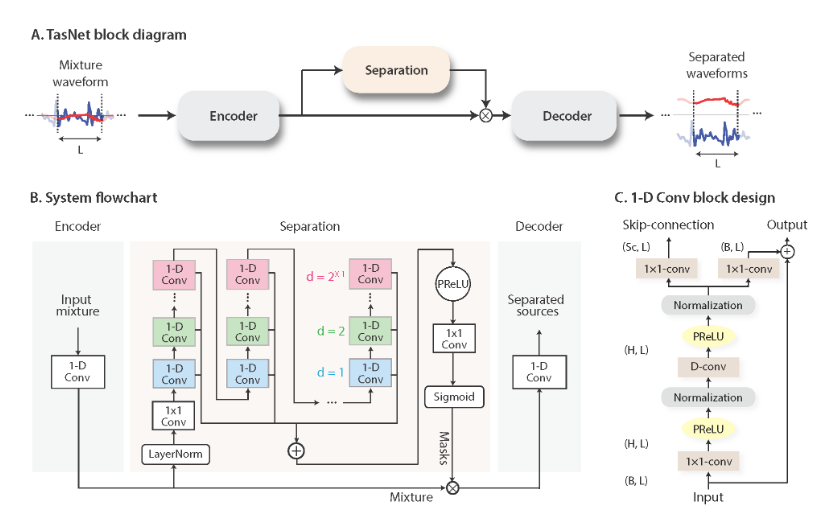

In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(
        self,
        io_channels: int,
        hidden_channels: int,
        kernel_size: int,
        padding: int,
        dilation: int = 1,
    ):
        super().__init__()

        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=io_channels, out_channels=hidden_channels, kernel_size=1),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
            torch.nn.Conv1d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=kernel_size,
                padding=padding,
                dilation=dilation,
                groups=hidden_channels,
            ),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
        )

        self.out = torch.nn.Conv1d(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)
        self.skip_co = torch.nn.Conv1d(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)

    def forward(self, input):
        feature = self.conv_layers(input)
        output = self.out(feature)
        skip_co = self.skip_co(feature)
        return output, skip_co

In [ ]:
class Mask(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        kernel_size: int,
        num_feats: int,
        num_hidden: int,
        num_layers: int,
        num_stacks: int,
    ):
        super().__init__()

        self.input_dim = input_dim

        self.input_norm = torch.nn.GroupNorm(num_groups=1, num_channels=input_dim, eps=1e-8)
        self.input_conv = torch.nn.Conv1d(in_channels=input_dim, out_channels=num_feats, kernel_size=1)

        self.conv_layers = torch.nn.ModuleList([])
        for stack in range(num_stacks):
            for layer in range(num_layers):
                self.conv_layers.append(
                    ConvBlock(
                        io_channels=num_feats,
                        hidden_channels=num_hidden,
                        kernel_size=kernel_size,
                        dilation=2**layer,
                        padding=2**layer
                    )
                )
        self.output_prelu = torch.nn.PReLU()
        self.output_conv = torch.nn.Conv1d(
            in_channels=num_feats,
            out_channels=input_dim * 2,
            kernel_size=1,
        )
        self.sigmoid = torch.nn.Sigmoid()
        

    def forward(self, input):
        batch_size = input.shape[0]
        feats = self.input_norm(input)
        feats = self.input_conv(feats)
        output = 0.0
        for layer in self.conv_layers:
            residual, skip = layer(feats)
            feats = feats + residual
            output = output + skip
        output = self.output_prelu(output)
        output = self.output_conv(output)
        output = self.sigmoid(output)
        return output.view(batch_size, 2, self.input_dim, -1)

In [ ]:
class TasNet(torch.nn.Module):
    def __init__(
        self,
        enc_kernel_size: int = 16,
        enc_num_feats: int = 512,
        
        msk_kernel_size: int = 3,
        msk_num_feats: int = 128,
        msk_num_hidden_feats: int = 512,
        msk_num_layers: int = 2,
        msk_num_stacks: int = 3,
    ):
        super().__init__()

        self.enc_num_feats = enc_num_feats
        self.enc_kernel_size = enc_kernel_size
        self.enc_stride = enc_kernel_size // 2

        self.encoder = torch.nn.Conv1d(
            in_channels=1,
            out_channels=enc_num_feats,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=False,
        )
        self.mask = Mask(
            input_dim=enc_num_feats,
            kernel_size=msk_kernel_size,
            num_feats=msk_num_feats,
            num_hidden=msk_num_hidden_feats,
            num_layers=msk_num_layers,
            num_stacks=msk_num_stacks
        )

        self.decoder = torch.nn.ConvTranspose1d(
            in_channels=enc_num_feats,
            out_channels=1,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=False,
        )
  
    def forward(self, input):
        batch_size, num_padded_frames = input.shape[0], input.shape[2]
        feats = self.encoder(input)
        masked = self.mask(feats) * feats.unsqueeze(1)
        masked = masked.view(batch_size * 2, self.enc_num_feats, -1)
        decoded = self.decoder(masked)
        output = decoded.view(batch_size, 2, num_padded_frames)
        return output[:, 0, :]

### Choice of loss function

The most commonly used loss functions for training deep neural networks are not always very efficient in speech denoising tasks. In this context we are looking for a loss that would accurately quantify the human perception of the similarity between two audio signals.

If we take the examples of the MSE and the L1 norm, these two losses operate on the time domain and they both output a high value for two identical signals that are only shifted from half a period even though these two signals would seem to be perfectly identical for a human ear.

A more subtle example is the L1 norm on frequency domain (L1 norm between the two spectrograms). This loss function does not replicate accurately the fact that the human ear acts as a filter and is biased towards some frequencies over some others. In contrast, it would sound as if the L1 norm would put more weight for a difference in the low frequencies than the human perception. A quick fix would consist in modulating the L1 norm by putting the weights that represent best the behavior of the human ear.

The articles below debate the choice of the loss function in audio denoising tasks:

*   https://arxiv.org/pdf/1911.08922.pdf FIR pre-emphasis filters (Perceptual transforms)
*   https://arxiv.org/pdf/1811.02508.pdf SDSDRLoss, SISDRLoss (both time domain)
*   https://arxiv.org/pdf/2010.10291.pdf RandomResolutionSTFTLoss, SumAndDifferenceSTFTLoss (both frequency domain)
*   https://arxiv.org/pdf/2202.07968.pdf comparison between various losses

We will use different loss functions for training and for evaluation: in order to assert the quality of the results obtained after the training we will use Short-time objective intelligibility (STOI) and perceptual evaluation of speech quality (PESQ) as two evaluation criteria.



In [ ]:
from torchmetrics import ScaleInvariantSignalNoiseRatio, SignalDistortionRatio, ScaleInvariantSignalDistortionRatio
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
from torchmetrics.audio.stoi import ShortTimeObjectiveIntelligibility

In [ ]:
def si_snr(pred: torch.Tensor, target: torch.Tensor, epsilon: float = 1e-8) -> float:
    pred -= pred.mean()
    target -= target.mean()
    
    target_pow = target.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (pred * target).mean(axis=1, keepdim=True)
    scale = mix_pow / (target_pow + epsilon)

    target = scale * target
    error = pred - target

    target_pow = target.pow(2)
    error_pow = error.pow(2)

    target_pow = target_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    return (10 * torch.log10(target_pow) - 10 * torch.log10(error_pow)).item()

In [ ]:
def l1_freq(pred: torch.Tensor, target: torch.Tensor) -> float:
    transform = torchaudio.transforms.Spectrogram()
    pred_spectrogram = transform(pred)
    target_spectrogram = transform(target)

    return (torch.sum(torch.abs(target_spectrogram - pred_spectrogram))).item()

In [ ]:
def choose_loss(loss_type: str):
    if loss_type == "sdr":
        return SignalDistortionRatio().to(device)
    elif loss_type == "sisdr":
        return ScaleInvariantSignalDistortionRatio().to(device)
    elif loss_type == "sisnr":
        return ScaleInvariantSignalNoiseRatio().to(device)
    elif loss_type == "mse":
        return nn.MSELoss().to(device)
    elif loss_type == "l1_time":
        return nn.L1Loss().to(device)
    elif loss_type == "l1_freq":
        return l1_freq
    raise ValueError(f"Incorrect loss type: {loss_type}.")

## Experiments

We came across a few issues with GPU memory usage on Google Colab, the utility function below will help keep track of the memory usage on GPU.

In [ ]:
def print_mem_info() -> None:
  print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024 ** 2 :.4f} MB")
  print(f"Memory reserved:  {torch.cuda.memory_reserved(0) / 1024 ** 2 :.4f} MB")

### Initialization

In [ ]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(big_train_signals),
    torch.Tensor(big_train_labels)
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
)
test_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(big_test_signals),
    torch.Tensor(big_test_labels)
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=10,
)

In [ ]:
# Get cpu or gpu device for training.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
model = TasNet().to(device)
print(model)

loss_fn = choose_loss("l1_freq")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

TasNet(
  (encoder): Conv1d(1, 512, kernel_size=(16,), stride=(8,), padding=(8,), bias=False)
  (mask): Mask(
    (input_norm): GroupNorm(1, 512, eps=1e-08, affine=True)
    (input_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
    (conv_layers): ModuleList(
      (0): ConvBlock(
        (conv_layers): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): GroupNorm(1, 512, eps=1e-08, affine=True)
          (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512)
          (4): PReLU(num_parameters=1)
          (5): GroupNorm(1, 512, eps=1e-08, affine=True)
        )
        (out): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
        (skip_co): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      )
      (1): ConvBlock(
        (conv_layers): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): GroupNorm(

In [ ]:
print(f"Our ConvTasNet has {count_parameters(model)} parameters.")

Our ConvTasNet has 1424013 parameters.


In [ ]:
print_mem_info()

Memory allocated: 5.4385 MB
Memory reserved:  12.0000 MB


### Run and results

In the run below we implement an online heuristic to update the learning rate in order to avoid oscillations.

In [ ]:
epochs = 20

loss_list_val, loss_list_test, pesq_list_test = [], [], []
test_loss, val_no_impv, halving = 10, 0, False
nb_pesq = PerceptualEvaluationSpeechQuality(8000, 'nb')

for t in range(epochs):
    try:
      print(f"Epoch {t + 1}\n-------------------------------")
      
      loss_test = train(train_dataloader, model, loss_fn, optimizer)
      prev_test_loss = test_loss
      test_loss, pesq_err = test(test_dataloader, model, loss_fn, nb_pesq)

      loss_list_val.append(test_loss)
      loss_list_test.append(loss_test)
      pesq_list_test.append(pesq_err)
      
      if test_loss >= prev_test_loss:
          val_no_impv += 1
          if val_no_impv >= 3:
              halving = True
          if val_no_impv >= 10:
              print("No improvement for 10 epochs, early stopping.")
              break
      else:
          val_no_impv = 0
      if halving:
          optim_state = optimizer.state_dict()
          optim_state['param_groups'][0]['lr'] = optim_state['param_groups'][0]['lr'] / 2.0
          optimizer.load_state_dict(optim_state)
          print(f"Learning rate adjusted to: {optim_state['param_groups'][0]['lr']:.6f}")
          halving = False

    except KeyboardInterrupt:
      print("\nExecution stopped.")
      break
    
print("Done!")

Epoch 1
-------------------------------
loss: 0.012994  [    0/ 2118]
loss: 0.012089  [  100/ 2118]
loss: 0.012211  [  200/ 2118]
loss: 0.012775  [  300/ 2118]
loss: 0.013709  [  400/ 2118]
loss: 0.010598  [  500/ 2118]
loss: 0.015674  [  600/ 2118]
loss: 0.010068  [  700/ 2118]
loss: 0.013917  [  800/ 2118]
loss: 0.011314  [  900/ 2118]
loss: 0.014564  [ 1000/ 2118]
loss: 0.013531  [ 1100/ 2118]
loss: 0.015261  [ 1200/ 2118]
loss: 0.011463  [ 1300/ 2118]
loss: 0.011307  [ 1400/ 2118]
loss: 0.013066  [ 1500/ 2118]
loss: 0.011072  [ 1600/ 2118]
loss: 0.010956  [ 1700/ 2118]
loss: 0.013513  [ 1800/ 2118]
loss: 0.010834  [ 1900/ 2118]
loss: 0.009656  [ 2000/ 2118]
loss: 0.012826  [ 2100/ 2118]
Test Error: 
 Avg loss: 0.013854 
 Avg pesq: 1.750832
Epoch 2
-------------------------------
loss: 0.014003  [    0/ 2118]
loss: 0.013828  [  100/ 2118]
loss: 0.008524  [  200/ 2118]
loss: 0.011277  [  300/ 2118]
loss: 0.010283  [  400/ 2118]
loss: 0.010074  [  500/ 2118]
loss: 0.014733  [  600/ 21

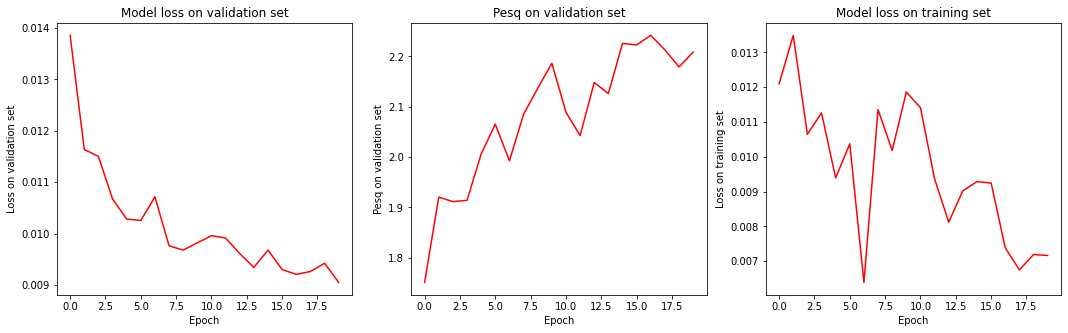

In [ ]:
plot_performance(loss_list_val, loss_list_test, pesq_list_test)

Mean PESQ between noisy signal and target signal:    2.0956
Mean PESQ between denoised signal and target signal: 2.3272

Mean STOI between noisy signal and target signal:    0.8456
Mean STOI between denoised signal and target signal: 0.8567



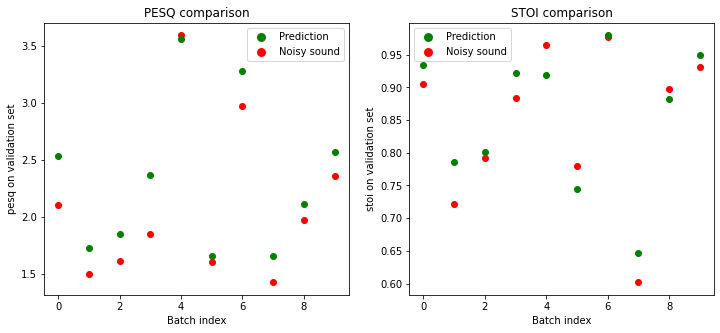


You can listen to one element in the batch (chosen randomly) using the widgets below.

Noisy signal




Target signal




Denoised signal



In [ ]:
with torch.no_grad():
  for X, y in test_dataloader:
      n = noise_test.shape[0]
      X, y = (
          get_data(X, n, "test").to(device),
          voice_test[y].to(device)
      )
      pred = model(X)
      break

compare_batch(X, y, pred)

### Comparison with a pretrained model

In [ ]:
%pip install asteroid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.3/246.3 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.2/398.2 KB 39.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 16.4 MB/s eta 0:00:00
  Created wheel for torch-stoi: filename=torch_stoi-

In [ ]:
from asteroid.models import ConvTasNet

model = ConvTasNet.from_pretrained('mpariente/ConvTasNet_WHAM!_sepclean').to(device)
print(model)

loss_fn = choose_loss("l1_freq")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using cached model `mpariente/ConvTasNet_WHAM!_sepclean`
ConvTasNet(
  (encoder): Encoder(
    (filterbank): FreeFB()
  )
  (masker): TDConvNet(
    (bottleneck): Sequential(
      (0): GlobLN()
      (1): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
    )
    (TCN): ModuleList(
      (0): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): GlobLN()
          (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512)
          (4): PReLU(num_parameters=1)
          (5): GlobLN()
        )
        (res_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
        (skip_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      )
      (1): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): GlobLN()
          (3): Conv1d(512, 512, kernel

In [ ]:
print(f"Asteroid's model has {count_parameters(model)} parameters.")

Asteroid's model has 5050545 parameters.


#### Directly using the pretrained model

Mean PESQ between noisy signal and target signal:    2.4673
Mean PESQ between denoised signal and target signal: 2.1217

Mean STOI between noisy signal and target signal:    0.9344
Mean STOI between denoised signal and target signal: 0.8477



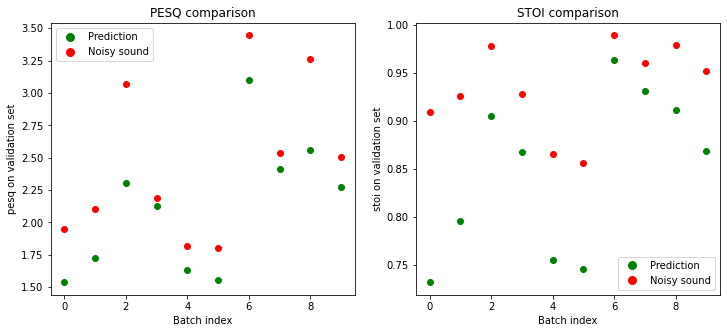


You can listen to one element in the batch (chosen randomly) using the widgets below.

Noisy signal




Target signal




Denoised signal



In [ ]:
with torch.no_grad():
  for X, y in test_dataloader:
      n = noise_test.shape[0]
      X, y = (
          get_data(X, n, "test").to(device),
          voice_test[y].to(device)
      )
      pred = model(X)[:,:1,:].squeeze()
      break

compare_batch(X, y, pred)

#### Retraining the model on our data

In [ ]:
epochs = 20

loss_list_val, loss_list_test, pesq_list_test = [], [], []
test_loss, val_no_impv, halving = 10, 0, False
nb_pesq = PerceptualEvaluationSpeechQuality(8000, 'nb')

for t in range(epochs):
    try:
      print(f"Epoch {t + 1}\n-------------------------------")
      
      loss_test = train(train_dataloader, model, loss_fn, optimizer)
      prev_test_loss = test_loss
      test_loss, pesq_err = test(test_dataloader, model, loss_fn, nb_pesq)

      loss_list_val.append(test_loss)
      loss_list_test.append(loss_test)
      pesq_list_test.append(pesq_err)
      
      if test_loss >= prev_test_loss:
          val_no_impv += 1
          if val_no_impv >= 3:
              halving = True
          if val_no_impv >= 10:
              print("No improvement for 10 epochs, early stopping.")
              break
      else:
          val_no_impv = 0
      if halving:
          optim_state = optimizer.state_dict()
          optim_state['param_groups'][0]['lr'] = optim_state['param_groups'][0]['lr'] / 2.0
          optimizer.load_state_dict(optim_state)
          print(f"Learning rate adjusted to: {optim_state['param_groups'][0]['lr']:.6f}")
          halving = False

    except KeyboardInterrupt:
      print("\nExecution stopped.")
      break
    
print("Done!")

Epoch 1
-------------------------------


OutOfMemoryError: ignored

This model is a lot bigger than our custom implementation of a ConvTasNet, which makes the gradient computation a lot more expensive in memory.

In [ ]:
plot_performance(loss_list_val, loss_list_test, pesq_list_test)

In [ ]:
with torch.no_grad():
  for X, y in test_dataloader:
      n = noise_test.shape[0]
      X, y = (
          get_data(X, n, "test").to(device),
          voice_test[y].to(device)
      )
      pred = model(X)
      break

compare_batch(X, y, pred)